In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from scipy.integrate import solve_ivp

In [2]:
def Θ(x, x_rev, λ, θ):
    xk, xj = np.meshgrid(x, x)
    return (xj - x_rev)/(1 + np.exp(-λ*(xk - θ)))

In [3]:
def dΘ_dx(x, λ, θ):
    final = np.ones((x.size, x.size))/(1 + np.exp(-λ*(x - θ)))
    np.fill_diagonal(final, final.diagonal() + x*λ*np.exp(-λ*(x - θ))/(1+np.exp(-λ*(x - θ)))**2)
    return final

In [4]:
def hr_dots(current, _, b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2):
    x, y, z = map(lambda k: k.flatten(), np.split(current, 3))
    theta = Θ(x, x_rev, λ, θ)
    dots = np.zeros_like(current).reshape(3, -1)
    dots[0] = y - (x**3) + b*(x**2) + i0 - z - (α/n1)*np.sum(G1*theta, axis=1) - (β/n2)*np.sum(G2*theta, axis=1)
    dots[1] = 1 - 5*(x**2) - y
    dots[2] = μ*(s*(x - x_rest) - z)
    return np.hstack(dots)

In [5]:
def jac(_, y_in):
    x, y, z = map(lambda k: k.flatten(), np.split(y_in, 3))
    dtheta_dx = dΘ_dx(x, λ, θ)
    dẋ_dx = -3*x**2 + 2*b*x - (α/n1)*G1*dtheta_dx - (β/n2)*G2*dtheta_dx
    dẋ_dy = np.ones_like(dẋ_dx)
    dẋ_dz = -np.ones_like(dẋ_dy)

    dẏ_dx = -10*x*np.ones_like(dẋ_dz)
    dẏ_dy = -np.ones_like(dẏ_dx)
    dẏ_dz = np.zeros_like(dẏ_dy)

    dż_dx = μ*s*np.ones_like(dẏ_dz)
    dż_dy = np.zeros_like(dż_dx)
    dż_dz = -μ*np.ones_like(dż_dy)

    j_x = [dẋ_dx, dẋ_dy, dẋ_dz]
    j_y = [dẏ_dx, dẏ_dy, dẏ_dz]
    j_z = [dż_dx, dż_dy, dż_dz]

    return np.vstack([np.hstack(j_x), np.hstack(j_y), np.hstack(j_z)])

In [6]:
def cortex_size(mask, val):
    return int(np.sqrt(mask[mask == val].shape))

In [7]:
def plot_final_state(
    y,
    cortices=None, legend=False,
    title=None, channel=0,
    markers=["ro", "k^", "gX", "bD"],
    ylim=[-1.5, 2.5]
):
    if cortices is None:
        cortices = [[0, y.size]]
    m = iter(markers[:len(cortices)])
    for cortex in cortices:
        plt.plot(range(*cortex), y[-1, channel, cortex[0]:cortex[1]], next(m), label=f"{cortex[0]} - {cortex[1] - 1}")
    if legend:
        plt.legend(loc="best")
    if title:
        plt.title(title)
    plt.ylim(ylim)

In [8]:
def plot_beginning_and_end(y, start, end, p=0.01, legend=False, title=True, channel=0):
    l = y.shape[0]
    fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True)
    for i in range(start, end):
        ax1.plot(y[:int(p*l), channel, i], label=i)
        ax1.grid(True)
        ax1.set_xlim([0, int(p*l)])
        ax2.plot(y[int((1 - p)*l):, channel, i], label=i)
        ax2.grid(True)
        ax2.set_xlim([0, int(p*l)])
        plt.ylim([-1.5, 2.25])
    if legend:
        ax1.legend(loc="lower left")
    if title:
        plt.suptitle(f"First and last {100*p}\% of neurons {start} - {end}")

In [9]:
def plot_state_diagram(y, cortices=None, lim=[-1.5, 2.5], markers=["ro", "k^", "gX", "bD"]):
    if cortices is None:
        cortices = [[0, y.size]]
    m = iter(markers[:len(cortices)])
    ytp1 = y[:-1]
    yt = y[1:]
    for cortex in cortices:
        plt.plot(yt[cortex[0]:cortex[1]], ytp1[cortex[0]:cortex[1]], next(m))
    plt.xlim(lim)
    plt.ylim(lim)

In [10]:
def event(t, y, i):
    return y[i]
event.direction = 1.0

In [11]:
def time_to_index(t, tmax, N, as_int=True):
    out = (N*t/tmax)
    if as_int:
        return out.astype(int)
    else:
        return out

In [12]:
def firing_time_mask(firing_timeses, tmax, N):
    times = np.linspace(0, tmax, N)
    k_mask = np.zeros((N, len(firing_timeses)))
    t_mask = k_mask.copy()
    tp1_mask = t_mask.copy() + 1
    for i, firing_times in enumerate(firing_timeses):
        for j, firing_time in enumerate(firing_times[:-1]):
            k_mask[times >= firing_time, i] += 1
            t_mask[times >= firing_time, i] = firing_time
            tp1_mask[times >= firing_time, i] = firing_times[j + 1]
    return k_mask.astype(int), t_mask, tp1_mask

In [13]:
def ϕ(sol, t):
    n_areas = len(sol.t_events)
    T = np.vstack(n_areas*[t]).T
    t_events = [sol.t_events[i] for i in range(n_areas)]
    k_mask, t_mask, tp1_mask = firing_time_mask(t_events, t[-1], t.size)
    return 2*np.pi*(k_mask + (T - t_mask)/(tp1_mask - t_mask))

In [14]:
def rp(state, ϵ=0.3):
    ϕi, ϕj = np.meshgrid(state, state)
    return np.heaviside(ϵ - np.abs(ϕi - ϕj), 0)

In [15]:
def non_central_sparseness(state):
    xx, yy = np.meshgrid(range(state.size), range(state.size))
    return np.sum(np.abs(xx - yy)*rp(state))

In [16]:
def σ(sol):
    diff = [np.diff(ts) for ts in sol.t_events]
    return np.array([np.var(d) for d in diff])

In [17]:
run = False
write = False

In [18]:
cortices = [[0, 18],
            [18, 28],
            [28, 46],
            [46, 65]]

In [19]:
n = np.loadtxt("../connectomes/cat_matrix.dat")/3
cortex_mask = np.zeros_like(n)
cortex_mask[:18, :18] = 1
cortex_mask[18:28, 18:28] = 2
cortex_mask[28:46, 28:46] = 3
cortex_mask[46:, 46:] = 4
G1 = n.copy()
G1[cortex_mask == 0] = 0
G2 = n.copy()
G2[cortex_mask != 0] = 0
events = [lambda t_in, y_in, i=i: event(t_in, y_in, i) for i in range(n.shape[0])]
for e in events:
    e.direction = 1.0

In [20]:
# For validation of the cortex sizes
for i in [1, 2, 3, 4]:
    print(i, cortex_size(cortex_mask, i))

1 18
2 10
3 18
4 19


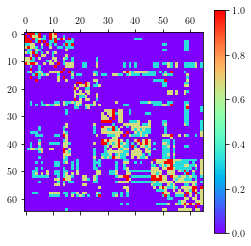

In [21]:
plt.matshow(n)
plt.colorbar()

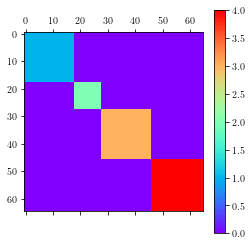

In [22]:
plt.matshow(cortex_mask)
plt.colorbar()

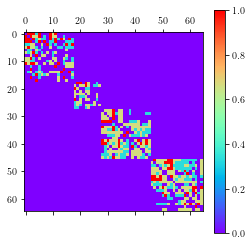

In [23]:
plt.matshow(G1)
plt.colorbar()

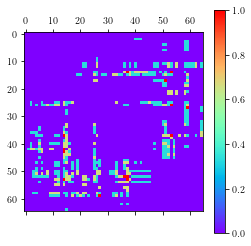

In [24]:
plt.matshow(G2)
plt.colorbar()

In [25]:
b = 3.2                           # Controls spiking frequency
i0 = 4.4*np.ones(n.shape[0])      # Input current ---- It's an array so we can add noise later
x_rev = 2                         # Reverse potential
λ = 10                            # Sigmoidal function parameter
θ = -0.25                         # Sigmoidal function parameter
μ = 0.01                          # Time scale of slow current
s = 4.0                           # Governs adaptation (whatever that means)
x_rest = -1.6                     # Resting potential ------ INCORRECT IN SANTOS PAPER
α = 0.210                         # Intra connection strength ---- VARIED PARAMETER
n1 = np.count_nonzero(G1, axis=1) # Number of intra connections from a given neuron
n1[n1 == 0] = 1                   # This is to remove a divide-by-zero; if n1 is 0, then so is G1
β = 0.040                         # Inter connection strength ---- VARIED PARAMETER
n2 = np.count_nonzero(G2, axis=1) # Number of inter connections from a given neuron
n2[n2 == 0] = 1                   # This is to remove a divide-by-zero; if n2 is 0, then so is G2

In [26]:
ivs = np.zeros([3, n.shape[0]])   # Initial values [[x], [y], [z]]
ivs[0] = 3.0*np.random.random(n.shape[0]) - 1.0
ivs[1] = 0.2*np.random.random(n.shape[0])
ivs[2] = 0.2*np.random.random(n.shape[0])

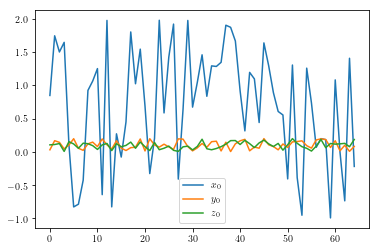

In [27]:
plt.plot(ivs[0], label=r"$x_{0}$")
plt.plot(ivs[1], label=r"$y_{0}$")
plt.plot(ivs[2], label=r"$z_{0}$")
plt.legend()

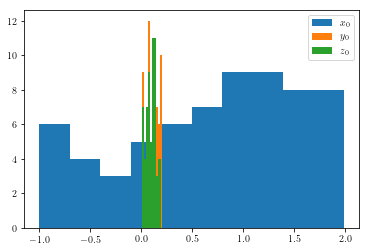

In [28]:
plt.hist(ivs[0], label=r"$x_{0}$")
plt.hist(ivs[1], label=r"$y_{0}$")
plt.hist(ivs[2], label=r"$z_{0}$")
plt.legend()

In [29]:
tmax = 4000
N = 100*tmax
t = np.linspace(0, tmax, N)

In [30]:
with open("../../data/0.770-0.253.pkl", "rb") as f:
    data = pickle.load(f)

In [31]:
phase = data[2]

In [32]:
order = np.sum(np.exp(phase*1j)/65, axis=1)

In [33]:
order.shape

(400000,)

(0, 1)

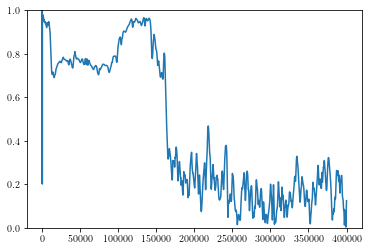

In [34]:
plt.plot(np.abs(order))
plt.ylim([0, 1])

In [35]:
vals = data[1].sol(t).T.reshape(-1, 3, 65)

In [36]:
vals.shape

(400000, 3, 65)

In [37]:
p = 0.01

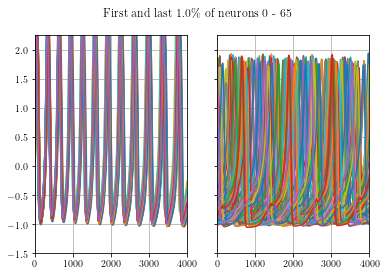

In [38]:
plot_beginning_and_end(vals, 0, 65, p=p, legend=False)

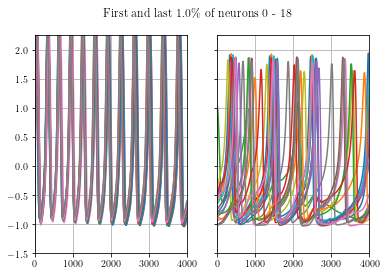

In [39]:
plot_beginning_and_end(vals, 0, 18, p=p)

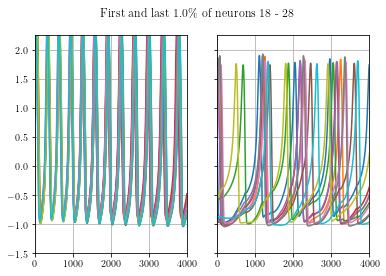

In [40]:
plot_beginning_and_end(vals, 18, 28, p=p)

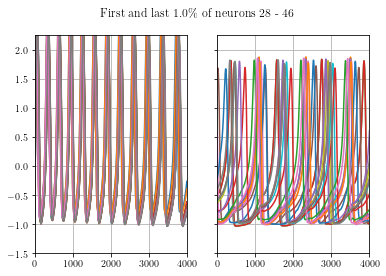

In [41]:
plot_beginning_and_end(vals, 28, 46, p=p)

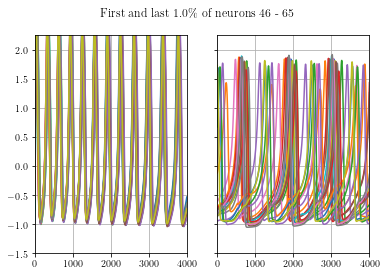

In [42]:
plot_beginning_and_end(vals, 46, 65, p=p)

In [43]:
cortices

[[0, 18], [18, 28], [28, 46], [46, 65]]

In [44]:
p=0.04
channel=0

In [45]:
vals.shape

(400000, 3, 65)

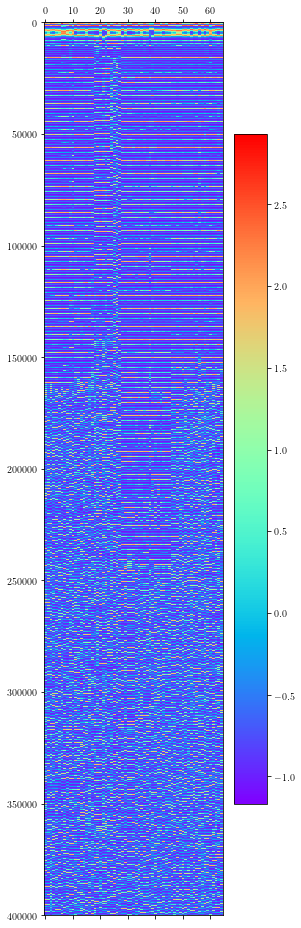

In [46]:
plt.matshow(vals[:, 0, :], aspect="auto")
plt.colorbar()

In [47]:
phase.shape

(400000, 65)

In [48]:
def order(phases):
    return np.abs(np.sum(np.exp(phases*1j), axis=1)/phases.shape[1])

def metastability(phase, cortices, p, channel=0):
    metastabilities = []
    N = int((1-p)*phase.shape[0])
    for cortex in cortices:
        ph = phase[N:, cortex[0]:cortex[1]]
        metastabilities.append(np.sum((order(ph) - np.mean(order(ph)))**2)/(N - 1))
    return np.mean(metastabilities)

def chimera(phase, cortices, p, channel=0):
    N = int((1-p)*phase.shape[0])
    chimeras = []
    M = len(cortices)
    average = np.mean([order(phase[N:, cortex[0]:cortex[1]]) for cortex in cortices])
    s = np.zeros(phase.shape[0] - N)
    for cortex in cortices:
        ph = phase[N:, cortex[0]:cortex[1]]
        s += (order(ph) - average)**2
    return s/(M - 1)

In [98]:
χ = chimera(phase, cortices, 1)

In [99]:
χ

array([0.22726171, 0.2272175 , 0.22686654, ..., 0.21121836, 0.21117213,
       0.21112571])

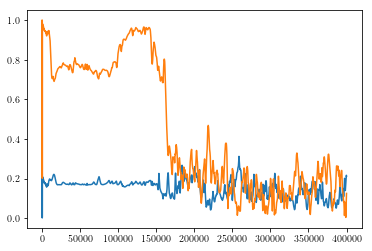

In [100]:
plt.plot(χ)
plt.plot(order(phase))

In [59]:
metastabilities = metastability(phase, cortices, 0.04)

In [60]:
metastabilities

0.00035299488177478787